Rubbish here.

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)

from astropy.io import fits
from astropy.units import degree, kpc
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import plotly
from plotly.offline import plot, iplot
import plotly.graph_objs as go

from matplotlib import pyplot as plt

In [2]:
data = fits.open('delta_transmission_RMplate_old.fits')
len(data)

1247

### Data Model

**PrimaryHDU**

In [3]:
data[0]

In [4]:
data[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

**BinaryTableHDU**

In [6]:
data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   24 / width of table in bytes                        
NAXIS2  =                 3466 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'LAMBDA  '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 'Angstrom'           / physical unit of field                         
TTYPE2  = 'DELTA_T '           / label for field   2                            
TFORM2  = 'D       '        

In [7]:
data[1].data.shape

(3466,)

In [8]:
data[1].data['LAMBDA'][:10]

array([4506.6, 4506.8, 4507. , 4507.2, 4507.4, 4507.6, 4507.8, 4508. ,
       4508.2, 4508.4])

In [9]:
data[1].data['DELTA_T'][:10]

array([0.32041982, 0.32820452, 0.32227549, 0.30720392, 0.32257604,
       0.37425373, 0.41448467, 0.43779907, 0.44572165, 0.42081868])

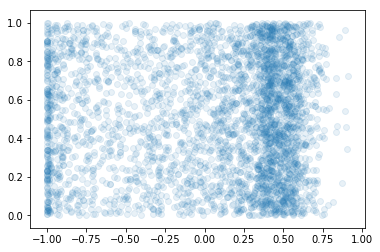

In [10]:
plt.scatter(data[1].data['DELTA_T'], np.random.rand(data[1].data.shape[0]), alpha=0.1)
plt.show()

In [11]:
data[1].data['RCOMOV'][:10]

array([4181.91557086, 4182.03612559, 4182.15668033, 4182.27723506,
       4182.3977898 , 4182.51834453, 4182.63887691, 4182.75938488,
       4182.87989285, 4183.00040082])

## 2D Visualization

### Extracting Coordinates from Header

In [12]:
ra_list = []
for i in range(1, len(data)):
    ra_list.append(data[i].header['RA'])
raw_ras = np.array(ra_list)
raw_ras.shape

(1246,)

In [13]:
dec_list = []
for i in range(1, len(data)):
    dec_list.append(data[i].header['DEC'])
raw_decs = np.array(dec_list)
raw_decs.shape

(1246,)

In [14]:
z_list = []
for i in range(1, len(data)):
    z_list.append(data[i].header['Z'])
zs = np.array(z_list)
zs.shape

(1246,)

In [43]:
def __read_skewer__(skewer):
    """
    Method for reading the angular positions, redshift, delta_t value, etc. for a skewer from fits file
    :param skewer: the skewer object in a fits file
    :return: lists of x coordinates, y coordinates, z coordinates, and delta_t values
    """
    ra_deg = skewer.header['RA']
    ra = np.deg2rad(ra_deg)
    dec_deg = skewer.header['DEC']
    dec = np.deg2rad(dec_deg)
    rcomov = skewer.data['RCOMOV']
    value = skewer.data['DELTA_T']

    x = np.sin(dec) * np.cos(ra) * rcomov
    y = np.sin(dec) * np.sin(ra) * rcomov
    z = np.cos(dec) * rcomov
    v = value

    return x, y, z, v

In [ ]:
def __get_matrix__(self):
    """
    Method for calculating rotation matrix
    :return:
    """
    ra, dec = self.__read_plate__()
    mean_ra, mean_dec = np.nanmean(ra), np.nanmean(dec)

    # Vector perpendicular to the above vector over which we rotate the co-ordinate system
    k_perp = np.array([-np.sin(mean_ra), np.cos(mean_ra), 0])

    # Rotation direction - Cross product matrix
    K = np.array([
        [0, -k_perp[2], k_perp[1]],
        [k_perp[2], 0, -k_perp[0]],
        [-k_perp[1], k_perp[0], 0]
    ])

    # ADOPTED FROM: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
    # Rotation Matrix to rotate the points vectors
    rot_matrix = np.eye(3) - np.sin(mean_dec) * K + (1 - np.cos(mean_dec)) * np.matmul(K, K)

    print('Rotation Matrix: ')
    print(self.rot_matrix)

    return self.rot_matrix

### Building Coordinate Systems

In [18]:
quasar_2d = SkyCoord(ra=ras*degree, dec=decs*degree, distance=zs*kpc, frame='icrs')
quasar_2d.shape

(1246,)

###  Astronomical Coordinate Systems - Equatorial

In [19]:
ra = quasar_2d[:].ra.value

In [20]:
dec = quasar_2d[:].dec.value

In [21]:
dis1 = quasar_2d[:].distance.value

In [22]:
rel_dis1 = dis1/dis1.max()

In [23]:
color1 = np.zeros((quasar_2d.shape[0], 4))
color1[:,3] = rel_dis1

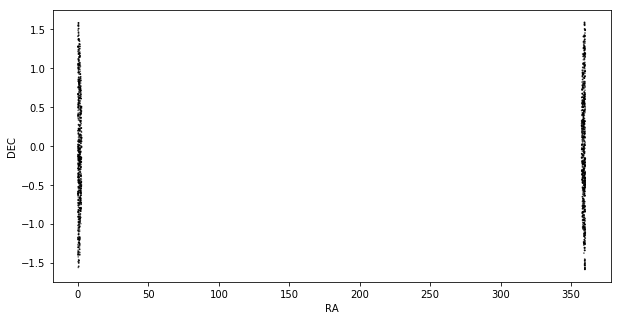

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(ra, dec, s=rel_dis1, c=color1)
# plt.scatter(lon2, lat2, s=0.5, c='k')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

###  Astronomical Coordinate Systems - Galactic

In [25]:
quasar_galactic = quasar_2d.galactic
quasar_galactic.shape

(1246,)

In [26]:
lon = quasar_galactic[:].l.value

In [27]:
lat = quasar_galactic[:].b.value

In [28]:
dis2 = quasar_galactic[:].distance.value

In [29]:
rel_dis2 = dis2/dis2.max()

In [30]:
color2 = np.zeros((quasar_galactic.shape[0], 4))
color2[:,3] = rel_dis2

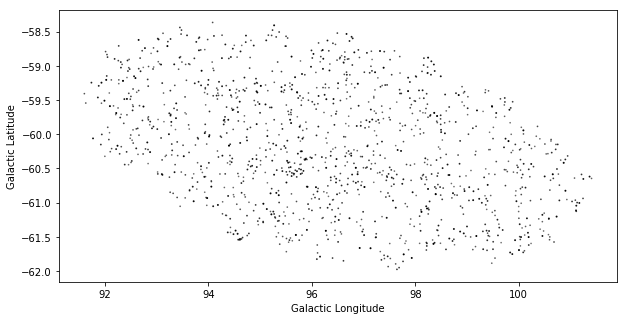

In [31]:
plt.figure(figsize=(10,5))
plt.scatter(lon, lat, s=rel_dis2, c=color2)
# plt.scatter(lon2, lat2, s=0.5, c='k')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()

### Cartesian Coordinate System

In [32]:
quasar_cartesian = quasar_2d.cartesian
quasar_cartesian.shape

(1246,)

In [33]:
quasar_cartesian[0]

<CartesianRepresentation (x, y, z) in kpc
    (3.33163714, -0.08892396, -0.04605836)>

In [34]:
x = quasar_cartesian[:].x.value

In [35]:
y = quasar_cartesian[:].y.value

In [36]:
z = quasar_cartesian[:].z.value

In [37]:
rel_z = (z + 0.1) * 5

In [38]:
color3 = np.zeros((quasar_cartesian.shape[0], 4))
color3[:,3] = rel_z

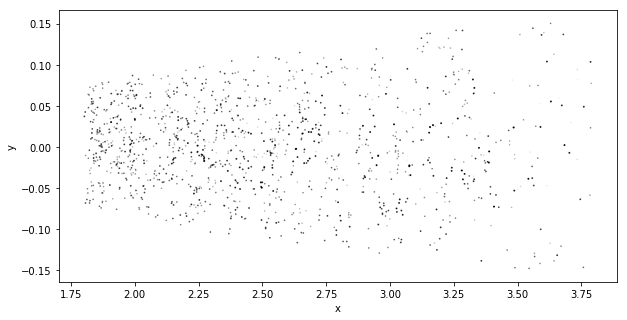

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(x, y, s=rel_z, c=color3)
# plt.scatter(lon2, lat2, s=0.5, c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 3D Visualization

In [41]:
def GetSkyCoord(data):
    ra = data.header['RA']
    dec = data.header['DEC']
    depth = data.data['RCOMOV']
    field = data.data['DELTA_T']
    sc = SkyCoord(ra=ra*degree, dec=dec*degree, distance=depth*kpc, frame='icrs')
    return sc

In [42]:
def GetField(data):
    return data.data['DELTA_T']

In [45]:
def Filter(sc, field, threshold=None):
    if threshold == None:
        return sc, field
    idx = field > threshold
    newField = field[idx]
    newSC = sc[idx]
    return newSC, newField

In [46]:
def randomFilter(sc, field, rate=1):
    if rate == 1:
        return sc, field
    size = field.shape[0]
    if (size == 0):
        idx = []
    else:
        idx = np.random.choice(field.shape[0], int(field.shape[0]*rate))
    newField = field[idx]
    newSC = sc[idx]
    return newSC, newField

In [47]:
data3d = []
threshold = -1
rate = 0.5

In [48]:
for i in range(1, len(data)):
    sc = GetSkyCoord(data[i])
    field = GetField(data[i])
    newSC, newField = randomFilter(sc, field, rate)
    cart = newSC.cartesian
    trace = go.Scatter3d(
        x=cart[:].x.value,
        y=cart[:].y.value,
        z=cart[:].z.value,
        mode='markers',
        marker=dict(
            size=2,
            color=field,
            opacity=0.5
        )
    )
    data3d.append(trace)

In [49]:
layout3d = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [50]:
fig = go.Figure(data=data3d, layout=layout3d)

In [51]:
plot(fig, filename='3dCartesian')

/Applications/anaconda3/lib/python3.6/site-packages/plotly/offline/offline.py:463: UserWarning:

Your filename `3dCartesian` didn't end with .html. Adding .html to the end of your file.



'file:///Users/yulong/Codes/astro-void/3dCartesian.html'